* [1.0 - Introduction](#1.0---Introduction)
    - [1.1 - Imports](#1.1---Imports)   
        
    
* [2.0 - Exploring the Raw Data](#2.0---Exploring-the-Raw-Data)
    - [2.1 - Finding the best pages to scrape](#2.1---Finding-the-best-pages-to-scrape)
    - [2.2 - Making the first request](#2.2---Making-the-first-request)    
    - [2.3 - Breaking down the raw data](#2.3---Breaking-down-the-raw-data)        


* [3.0 - Parsing and Cleaning the Reviews Data](#3.0---Parsing-and-Cleaning-the-Reviews-Data)
    - [3.1 - Parsing the primary key, review_id](#3.1---Parsing-the-primary-key,-review_id)
    - [3.2 - Parsing the foreign key, anime_id](#3.2---Parsing-the-foreign-key,-anime_id)
    - [3.3 - Parsing and cleaning review information](#3.3---Parsing-and-cleaning-review-information)
    - [3.4 - Parsing and cleaning review ratings](#3.4---Parsing-and-cleaning-review-ratings)    
    - [3.5 - Parsing and cleaning review body and helpful counts](#3.5---Parsing-and-cleaning-review-body-and-helpful-counts)


* [4.0 - Building the SQL Database](#4.0---Building-the-SQL-Database)
    - [4.1 - Primary keys](#4.1---Primary-keys)        
    - [4.2 - Foreign keys](#4.2---Foreign-keys)        
    - [4.3 - Creating the database schema](#4.3---Creating-the-database-schema)     
    - [4.4 - Inserting data into the tables](#4.4---Inserting-data-into-the-tables)     


* [5.0 - Special Considerations](#5.0---Special-Considerations)
    - [5.1 - Sleep times](#5.1---Sleep-times)        
    - [5.2 - Request errors](#5.2---Request-errors)        
    - [5.3 - Monitoring the scraping progress](#5.3---Monitoring-the-scraping-progress) 
    - [5.4 - Summary of the web scraping process](#5.4---Summary-of-the-web-scraping-process)


* [6.0 - Exploratory Data Analysis](#6.0---Exploratory-Data-Analysis)
    - [6.1 - The top 10 highest rated genres](#6.1---The-top-10-highest-rated-genres)
    - [6.2 - Number of genres and ratings](#6.2---Number-of-genres-and-ratings)  
    - [6.3 - The highest rated studio](#6.3---The-highest-rated-studio)
    - [6.4 - Source material and ratings](#6.4---Source-material-and-ratings)  
    

![database_schema](https://raw.githubusercontent.com/sengkchu/MAL-reviews-scraper/master/databaseschema.PNG)

### 1.0 - Introduction

Data is all arround us, but getting that data and processing it into a readable format is usually the most time consuming part of any data pipeline. In this notebook, I will focus on web scraping using BeautifulSoup. The idea is to come up with a generic process that can be used for most websites and turn the internet itself into a data source. We also want to scrape the website in such a way that follows the "tidy data" format based on the [paper](http://vita.had.co.nz/papers/tidy-data.html) by Hadley Wickham.

The target for this project will be [MyAnimeList.net](https://myanimelist.net/), an anime review website where users can sign up and give a review and/or a rating on various animes. This website is similar to IMDB, but it is focused on Japanese animation. I am going to showcase the methodology of scraping this website into a SQLite database that can be easily queried.

I will also do a bit of data analysis using SQL and pandas to explore the following questions:

+ What are the top 10 genres by popularity and rating?
+ Is there a correlation between the number of genres vs. ratings?
+ What is the studio with the highest average rating for the anime they've produced?
+ Is there a conection between source material of an anime vs. ratings?

For a complete list of requirements and the detailed code for this project, check out my GitHub repository [here](https://github.com/sengkchu/MAL-reviews-scraper).


#### 1.1 - Imports

We will use `requests.get()` for getting the raw data, and `BeautifulSoup` for parsing the HTML data. `time`, `random` are used for adding intervals between requests, so we don't hammer the servers with too many requests.

For data storage, we will use `sqlite3`. For data analysis, we will use `pandas`, `seaborn`, `numpy`, and `matplotlib`.

In [1]:
from requests import get
from bs4 import BeautifulSoup
import time
import random
import math
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(font_scale=1.5)

### 2.0 - Exploring the Raw Data

Before we start, we have to find out what pages we want to target for this project. I did not come up the database schema from the start. This was something I thought about later down the line. This is a top-down approach where we first thinking about what kind of data we are looking for, then we build our database around the initial data.

#### 2.1 - Finding the best pages to scrape

For this project, we are mainly interested in the reviews data. I usually try to look for webpages that fits the following:

+ URL structure with a pattern.
+ Contains as much data as possible.
+ Relatively easy to parse.

In addition, we have to think about how we will structure our relational database to store the data along the way.

![reviews_container](https://raw.githubusercontent.com/sengkchu/MAL-reviews-scraper/master/Methodology%20and%20data%20analysis/reviews_container.PNG)

This page has about 50 of these containers. So we are scraping 50 reviews everytime we make a request. I highlighted some of the information we want to scrape. The URL structure is also easy to identify. 

<center>![reviews_url](https://raw.githubusercontent.com/sengkchu/MAL-reviews-scraper/master/Methodology%20and%20data%20analysis/reviews_url.PNG)</center>

The URL structure is also easy to identify. We can set up a for loop from p=1 to p=N. 

#### 2.2 - Making the first request

The next step is to see what the raw data looks like, all we have to do is enter the URL and the `get()` function. The headers is what people on the server side sees, generally it is a good idea to be courteous and explain why you are scraping their data.

In [2]:
url = 'https://myanimelist.net/reviews.php?t=anime&p=6'
headers = {
        "User-Agent": "mal review scraper for research."
}
response = get(url)
print(response.status_code)

200


A response 200 indicates that the request was successful. Next, we'll use beautiful soup to find out what the data looks like.

In [3]:
html_soup = BeautifulSoup(response.text, 'html.parser')

<center>![reviews_mess](https://raw.githubusercontent.com/sengkchu/MAL-reviews-scraper/master/Methodology%20and%20data%20analysis/reviews_mess.PNG)</center>

Now this is where the fun part begins, we have to figure out a pattern in the soup object, so we can extract the same data for every single container on this page.

#### 2.3 - Breaking down the raw data

Reading the HTML mess in Python is very tedious, it is a better idea to use the developer tools in Firefox or Chrome to explore the HTML. 
![reviews_inspect](https://raw.githubusercontent.com/sengkchu/MAL-reviews-scraper/master/Methodology%20and%20data%20analysis/reviews_inspect.PNG)

![reviews_source](https://raw.githubusercontent.com/sengkchu/MAL-reviews-scraper/master/Methodology%20and%20data%20analysis/reviews_source.PNG)

The inspect element feature on the browser is very useful for navigating the HTML code. Jumping into the HTML code on the page, we immediately see that each container is separated by `div` and `class = 'borderDark'`. Using the `.find_all()` method we can get a list of the 50 review containers.

In [4]:
review_containers = html_soup.find_all('div', class_ = 'borderDark')
len(review_containers)

50

### 3.0 - Parsing and Cleaning the Reviews Data

Now that we've split the page into 50 review containers, let's see what the review container look like. This data is still extremely messy, but it should be easier to work with than before. 

This is the most time consuming part of the web scraping process. Personally, I learned a lot of parsing techniques from this blog post from dataquest [here](https://www.dataquest.io/blog/web-scraping-beautifulsoup/). Going into the extreme details of the parsing techniques used is a bit beyond the scope of this notebook, but I will talk about the general methodology of the process.

In [5]:
review = review_containers[22]

![review_preview](https://raw.githubusercontent.com/sengkchu/MAL-reviews-scraper/master/Methodology%20and%20data%20analysis/reviews_preview.PNG)

#### 3.1 - Parsing the primary key, review_id

When building a SQL database, we have to determine what to use a primary key. The primary key ensures that only unique reviews get added into the database. Luckily, each review container has an ID stored within the metadata of the HTML.

Playing arround with the `.find_all()` method and its attributes, `.attrs[]` gives us this result.

In [6]:
review_id = review.find_all(
    'div', attrs={'style':"float: left; display: none; margin: 0 10px 10px 0"})[0].attrs['id']
review_id


'score278933'

This data is a slightly dirty, we can use `.replace()` to get rid of the text.

In [7]:
review_id = review_id.replace('score', '')
review_id

'278933'

#### 3.2 - Parsing the foreign key, anime_id

We also have to think about what to use a foreign key to build upon our data. The reviews section does not have much information on the anime itself. So it is a good idea to scrape the anime_id for later use.

We'll have to use `.find()` method and search for the class associated with the anime_id.

In [8]:
anime_id = review.div.find('a', class_='hoverinfo_trigger').attrs['rel'][0]
anime_id

'#revInfo35849'

In [9]:
anime_id = anime_id.replace('#revInfo', '')
anime_id

'35849'

#### 3.3 - Parsing and cleaning review information

Using the similar method of using inspect element on the browser along with beautiful soup, we can parse and clean the rest of the data.

In [10]:
review_element = review.div
anime_name = review_element.find('a', class_='hoverinfo_trigger').text         
username = review_element.find_all('td')[1].a.text
review_date = review_element.div.div.text
episodes_seen = review_element.div.find_all('div')[1].text.strip().split(' ')[0]

#### 3.4 - Parsing and cleaning review ratings

In [11]:
overall_rating = review_element.div.find_all('div')[2].text.strip().split('\n')[1]
story_rating = review.find_all('td', class_='borderClass')[3].text
animation_rating = review.find_all('td', class_='borderClass')[5].text
sound_rating = review.find_all('td', class_='borderClass')[7].text
character_rating = review.find_all('td', class_='borderClass')[9].text    
enjoyment_rating = review.find_all('td', class_='borderClass')[11].text

#### 3.5 - Parsing and cleaning review body and helpful counts

The body text is slightly different from the rest of the data. We'll have to use `.select()` to select the class and `contents()` to open up the contents of the class. The body of the review is located at the 5th and 6th element of the list.

In [12]:
#Review helpful counts
helpful_counts = review_element.find('span').text

#Review Body
body1 = review.select('div.spaceit.textReadability.word-break.pt8')[0].contents[4].strip()
body2 = review.select('div.spaceit.textReadability.word-break.pt8')[0].contents[5].text.strip()
review_body = (body1 + ' ' + body2)
review_body[0:500]

'What do you get if you mix a whole lot of Evangelion, a decent amount of Elfen Leid and just a pinch of Mirai Nikki? You get Darling in the FranXX. This review is spoiler free, and aimed at those contemplating whether or not to watch the series.\n\r\n[THEMES/STORY]:\n\r\n"Jian, also known as \'the bird who shares wings\', only possess one wing. Unless a male and female pair lean on each other and act as one, they\'re incapable of flight" - Ep 1.\n\r\nThis show is a little like Madoka Magica in that you will'

Next, we'll have to clean up the `\n` and `\r` from the body section. We'll just replace these with spaces.

In [13]:
review_body = (body1 + ' ' + body2).replace('\n', ' ').replace('\r', ' ')
review_body[0:500]

'What do you get if you mix a whole lot of Evangelion, a decent amount of Elfen Leid and just a pinch of Mirai Nikki? You get Darling in the FranXX. This review is spoiler free, and aimed at those contemplating whether or not to watch the series.   [THEMES/STORY]:   "Jian, also known as \'the bird who shares wings\', only possess one wing. Unless a male and female pair lean on each other and act as one, they\'re incapable of flight" - Ep 1.   This show is a little like Madoka Magica in that you will'

That is it for prototyping the reviews scraper! So far, we managed to scrape data from one container on one page. We can apply a similar process for scraping anime information, tags, and studio names. Then use a for loop to scrape every container on every page. The detailed code for parsing/cleaning of the data on the other tables can be found in my GitHub repository.

### 4.0 - Building the SQL Database

The next problem we need to tackle is data storage. While it is possible to store everything in memory using pandas, it makes more sense to store the information into a SQL database. If the dataset is very large, I am pretty sure my computer will run out of memory.

First, let's start off with some helper functions.

In [14]:
def run_query(DB, q):
    with sqlite3.connect(DB) as conn:
        return pd.read_sql(q,conn)

def run_command(DB, c):
    with sqlite3.connect(DB) as conn:
        conn.execute('PRAGMA foreign_keys = ON;')
        conn.isolation_level = None
        conn.execute(c)
        
def run_inserts(DB, c, values):
    with sqlite3.connect(DB) as conn:
        conn.execute('PRAGMA foreign_keys = ON;')
        conn.isolation_level = None
        conn.execute(c, values) 

I created three helper functions:
+ `run_query()` reads a SQL query and returns a pandas dataframe,
+ `run_command()` executes a SQL command with consideration of foreign keys and autocommit changes.
+ `run_inserts()` executes a SQL command specifically used for writing into the database.

#### 4.1 - Primary keys

The first thing we'll have to think about is what to use as a primary key. If we are scraping data from the internet, we probably want to avoid generating our own primary keys using `AUTOINCREMENT`. Internet pages are usually dynamic, and we want to make sure we don't scrape the same thing twice.

So far, we know we can scrape `anime_id` and `review_id` directly. But, we also have to consider that every anime has its own studio, and genres. We can get this information off the url structure itself.

![genre_studio_url](https://raw.githubusercontent.com/sengkchu/MAL-reviews-scraper/master/Methodology%20and%20data%20analysis/studio_genre_url.PNG)

#### 4.2 - Foreign keys

So far we have the following primary keys:

+ review_id
+ anime_id
+ tag_id
+ studio_id

Now we have to think about how to relate these keys with each other. A studio can produce many animes, and each anime can have many reviews. Immediately, we know we should relate these three ids together using foreign keys.

But what about the tags(genres)? An anime can have many tags, and each tag can have many animes. The solution to problem is to create a many to many intermediate table. This table will store the anime_ids and tag_ids together as a key.

#### 4.3 - Creating the database schema

At the end of the day, we have the following database schema,

![database_schema](https://raw.githubusercontent.com/sengkchu/MAL-reviews-scraper/master/databaseschema.PNG)

Now we just have to write some SQL queries to create the database. The detailed queries to make create the above tables can be found in createtables.py.

#### 4.4 - Inserting data into the tables

Okay, so we have the database schema, now we have to think about how to write down the information into the database. We can accomplish this by using an INSERT command. 

In [15]:
DB = 'anime.db'

insert_command = '''
INSERT OR IGNORE INTO reviews(
    review_id,
    anime_id, 
    username, 
    review_date,
    episodes_seen,
    overall_rating,
    story_rating,
    animation_rating,
    sound_rating,
    character_rating,
    enjoyment_rating,
    helpful_counts,    
    review_body
    ) 
VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
'''

run_inserts(
    DB, insert_command,(
        int(review_id), int(anime_id), username, review_date, \
        episodes_seen, int(overall_rating), \
        int(story_rating), int(animation_rating), int(sound_rating), \
        int(character_rating), int(enjoyment_rating), int(helpful_counts), review_body
    )
)

### 5.0 - Special Considerations

When we apply a for loop to our prototype, we could potentially hammer the servers with too many requests. It is generally a good idea to be courteous when extracting information from another website as a third party application.

In addition, we also want a way to monitor our for loop using `print()` functions and handle any potential errors that can occur.

####  5.1 - Sleep times

We can artificially inject a sleep time in between each iteration of the for loop using `time.sleep()`. We also want to mimic human behavior by varying the sleep times. This can be accomplished by using `random.uniform()` which selects a random float value between two integers.

In [16]:
sleep_min = 2
sleep_max = 5

start_time = time.time()
for i in range(1, 4):
    time.sleep(random.uniform(sleep_min, sleep_max))
    print('Loop #: {}'.format(i))
    print('Elapsed Time: {} seconds'.format(time.time() - start_time))
      

Loop #: 1
Elapsed Time: 2.1878020763397217 seconds
Loop #: 2
Elapsed Time: 6.901684284210205 seconds
Loop #: 3
Elapsed Time: 9.803745985031128 seconds


#### 5.2 - Request errors

If our internet goes out in the middle of the loop or if we reach a page that doesn't exist. We want to print out an error message and log the error. For simplicity of this example, I dumped the error onto a list. In the actual script, we probably want to write the errors into a text file.

In [17]:
sleep_min = 2
sleep_max = 5

log = []
for i in range(30000, 30003):
    time.sleep(random.uniform(sleep_min, sleep_max))
    url = 'https://myanimelist.net/reviews.php?t=anime&p={}'.format(i)
    headers = {
        "User-Agent": "mal review scraper for research."
    }

    print('Scraping: {}'.format(url))

    
    try:
        response = get(url, headers=headers, timeout = 10)
    except:
        print('Request timeout')
        log.append('Request timeout for {}'.format(url))
        pass

    if response.status_code != 200:
        print('Status code: {}'.format(response.status_code))
        log.append('Status code: {0} {1}'.format(response.status_code, url))
        pass

print(log)

Scraping: https://myanimelist.net/reviews.php?t=anime&p=30000
Request timeout
Scraping: https://myanimelist.net/reviews.php?t=anime&p=30001
Request timeout
Scraping: https://myanimelist.net/reviews.php?t=anime&p=30002
Status code: 404
['Request timeout for https://myanimelist.net/reviews.php?t=anime&p=30000', 'Request timeout for https://myanimelist.net/reviews.php?t=anime&p=30001', 'Status code: 404 https://myanimelist.net/reviews.php?t=anime&p=30002']


#### 5.3 - Monitoring the scraping progress

Lastly, we want to include status messages that answers the following questions:

+ What page are we scraping?
+ How much time has passed?
+ How many requests are we making per second?

In [18]:
start_time = time.time()
sleep_min = 2
sleep_max = 5
page_start = 1
page_end = 5

for i in range(page_start, (page_end+1)):
    time.sleep(random.uniform(sleep_min, sleep_max))
    current_time = time.time()
    elapsed_time = current_time - start_time
    requests = i    

    print('Requests Completed: {}; Frequency: {} requests/s'.format(requests, requests/elapsed_time))
    print('Elapased Time: {} minutes'.format(elapsed_time/60))
    if requests == page_end:
        print('Scrape Complete')
        break
    print('Pausing...')    
       

Requests Completed: 1; Frequency: 0.22681064403497714 requests/s
Elapased Time: 0.07348273595174154 minutes
Pausing...
Requests Completed: 2; Frequency: 0.23399229878595026 requests/s
Elapased Time: 0.14245483080546062 minutes
Pausing...
Requests Completed: 3; Frequency: 0.2287163979898191 requests/s
Elapased Time: 0.21861134767532348 minutes
Pausing...
Requests Completed: 4; Frequency: 0.2501008731176358 requests/s
Elapased Time: 0.26655911207199096 minutes
Pausing...
Requests Completed: 5; Frequency: 0.2383797038429263 requests/s
Elapased Time: 0.3495823343594869 minutes
Scrape Complete


#### 5.4 - Summary of the web scraping process

That is everything we need to put together a script to scrape the website! Please checkout my GitHub repository for the result!

In summary, this is the process I would follow:

![summary](https://raw.githubusercontent.com/sengkchu/MAL-reviews-scraper/master/Methodology%20and%20data%20analysis/summary.PNG)

### 6.0 - Exploratory Data Analysis

For the rest of this notebook, I will demonstrate several SQL queries on the database after we finished scraping the website. Suppose we are an anime studio looking to produce the next big anime. We want to do lots of research on the following:

+ What is the genre of the anime we should go for?
+ How many genres should we include in the anime?
+ What should we use as the source material for the anime adaption?
+ What is the highest rated studio? Maybe we can learn a bit from their success?

Maybe that will give us some ideas of what the consumers are interested in.

#### 6.1 - The top 10 highest rated genres

Determining the top 10 highest rated genres is very simple with the SQL databse, a basic `SELECT` query should do the trick. Unfortunately, SQLite does not have STDEV as an aggregate function. In addition, we have null values in the `overall_ratings` so we'll use pandas for the null values.

In [19]:
testq = '''
SELECT 
    t.tag_id tag_id,
    t.tag_name Genre,
    a.anime_id,
    a.overall_rating
FROM animes a
INNER JOIN anime_tags at ON a.anime_id = at.anime_id
INNER JOIN tags t ON at.tag_id = t.tag_id

'''

table1 = run_query(DB, testq)
table1.tail()

,tag_id,Genre,anime_id,overall_rating
41424,37,Supernatural,7495,null
41425,37,Supernatural,35709,null
41426,32,Vampire,3801,4.13
41427,33,Yaoi,6546,5.07
41428,33,Yaoi,9232,6.09


In [20]:
#Handle null values
table1['overall_rating_std'] = pd.to_numeric(table1['overall_rating'], errors='coerce').dropna()
table1['overall_rating_mean'] = pd.to_numeric(table1['overall_rating'], errors='coerce').dropna()
table1['sample_size'] = 0

table1_cleaned = table1.groupby(['tag_id', 'Genre'], as_index = False).agg({'overall_rating_std': np.std, 'overall_rating_mean': np.mean, 'sample_size': len})
table1_cleaned = table1_cleaned.sort_values(by=['overall_rating_mean'], ascending = False).head(10)
table1_cleaned

,tag_id,Genre,overall_rating_std,sample_size,overall_rating_mean
40,41,Thriller,1.123790,97,7.302045
42,43,Josei,0.783113,81,7.254667
6,7,Mystery,0.835486,602,7.224606
26,27,Shounen,0.716568,1756,7.132192
38,39,Police,0.808493,219,7.129677
7,8,Drama,0.801834,2276,7.064534
41,42,Seinen,0.788471,691,7.048993
36,37,Supernatural,0.873404,1199,7.014661
22,23,School,0.758184,1397,7.000718
21,22,Romance,0.760988,1623,6.994559


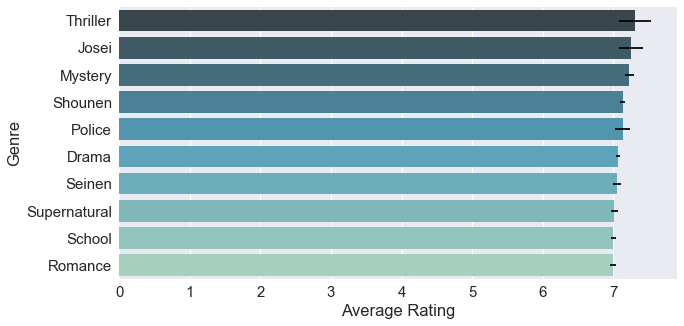

In [21]:
y = table1_cleaned['Genre']
x = table1_cleaned['overall_rating_mean']
std = table1_cleaned['overall_rating_std']
xerr = 1.96*std/np.sqrt(table1_cleaned['sample_size']).values

fig = plt.figure(figsize=(10,5))
ax = sns.barplot(x, y, xerr=xerr, palette='GnBu_d')
ax.set_xlabel('Average Rating')
plt.show()

A brief look at the ratings above, the average rating of the top 10 genres are all fairly close to each other. 'Thriller' animes are rated the highest on average, but the sample size is small (< 100). Maybe genre isn't the only thing we need to produce a high rated anime. This makes sense because an anime can have fit into many genres, or 'tags'. We need to pursue the question further. 

#### 6.2 - Number of genres and ratings

Okay, maybe if an anime incorporates many genres, maybe that will improve the rating? Once again, we can query SQL to grab the information we need.

In [22]:
q2 = '''
WITH anime_genre_counts AS
    (SELECT
        a.anime_id,
        COUNT(at.anime_id) Number_of_genres,
        AVG(a.overall_rating) overall_rating
    FROM animes a
    INNER JOIN anime_tags at ON a.anime_id = at.anime_id
    INNER JOIN tags t ON at.tag_id = t.tag_id
    GROUP BY 1
    )

SELECT
    Number_of_genres,
    COUNT(anime_id) sample_size,
    AVG(overall_rating) Average_rating
FROM anime_genre_counts
GROUP BY 1
ORDER BY 3 DESC
'''

table2 = run_query(DB, q2)
table2

,Number_of_genres,sample_size,Average_rating
0,13,1,6.930000
1,7,255,6.880471
2,11,2,6.880000
3,10,15,6.808667
4,6,664,6.803449
5,8,79,6.783418
6,5,1424,6.540716
7,9,39,6.339744
8,4,2180,6.188445
9,3,2939,5.107383


It is hard to draw conclusions from this query. We see that animes with 1 or 2 genres tagged are all the way at the bottom. This is because unpopular animes do not get tagged as often. Whereas popular animes get tagged a lot more.

#### 6.3 - The highest rated studio

Next we want to look for high rated studios. Once again, we'll use a SQL query. We also want to avoid looking up anime movies. So we'll set the episodes_total constraint to at least 10. We also want to avoid looking up studios that got lucky and produced a huge hit by pure chance, so we'll set the anime_produced constraint to at least 10 as well.

In [23]:
q3 = '''
WITH anime_studios AS
    (SELECT
        s.studio_name,
        COUNT(a.anime_id) animes_produced,
        AVG(a.overall_rating) overall_rating,
        episodes_total
    FROM animes a
    INNER JOIN studios s ON s.studio_id = a.studio_id
    WHERE episodes_total > 10
    GROUP BY 1
    )

SELECT
    studio_name,
    animes_produced,
    overall_rating average_ratings
FROM anime_studios
WHERE animes_produced > 10
ORDER BY average_ratings DESC
LIMIT 10
'''

table3 = run_query(DB, q3)
table3

,studio_name,animes_produced,average_ratings
0,Tezuka_Productions,13,7.316154
1,Shaft,66,7.310758
2,Bones,73,7.307671
3,TYO_Animations,14,7.252857
4,Brains_Base,63,7.209841
5,Hal_Film_Maker,24,7.202083
6,Seven_Arcs,15,7.152000
7,Collaboration_Works,11,7.148182
8,Studio_Gokumi,18,7.140556
9,David_Production,18,7.133889


The number of animes these top studios produced are a bit on the low end. However, we should definitely look into studios like 'Shaft', 'Brains_base', and 'Bones'.

#### 6.4 - Source material and ratings

In [24]:
q4 = '''
SELECT
    source_material,
    COUNT(anime_id) sample_size,
    AVG(overall_rating) average_ratings
FROM animes
GROUP BY source_material
ORDER BY average_ratings DESC
LIMIT 10
'''

table4 = run_query(DB, q4)
table4

,source_material,sample_size,average_ratings
0,Light novel,562,6.826477
1,Manga,3069,6.447520
2,Visual novel,883,6.430555
3,4-koma manga,220,6.025773
4,Novel,344,5.817006
5,Digital manga,8,5.801250
6,Card game,56,5.639464
7,Game,584,5.600051
8,Web manga,145,4.958828
9,Original,3236,4.331805


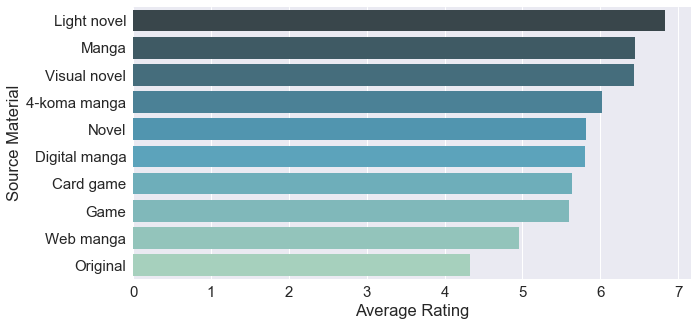

In [25]:
y = table4['source_material']
x = table4['average_ratings']

fig = plt.figure(figsize=(10,5))
ax = sns.barplot(x, y, palette='GnBu_d')
ax.set_xlabel('Average Rating')
ax.set_ylabel('Source Material')
plt.show()

From the data above, we see that original series generally do not perform very well. Where as adaptations based on light novels, mangas, and visual novels tend to do a lot better. This is mainly due to the fact that adaptations based on other works already have a following to the series. It is much harder to obtain new viewers as an original series.